# 💖 Mental Health Sentiment Analysis using Deep Learning (RoBERTa) 🧠

<div style="text-align: center;">
  <img src="https://i.pinimg.com/736x/14/57/8e/14578edd117e0e6e99aebe86175953f9.jpg" alt="mentalhealth" width="360"/>
</div>

### 🌟 Why It Matters

#### In our increasingly interconnected world, where lives unfold across digital landscapes, the silent cries and subtle expressions of mental health struggles often go unheard. Yet, hidden within the vast sea of online content—social media posts, forum discussions, and personal blogs—lies something invaluable: the raw, unfiltered essence of human emotion.

#### To truly understand these sentiments is more than a technological endeavor; it is an act of deep empathy. It’s a commitment to listening with care, to acknowledging unseen pain, and to building a society that responds with compassion and support.

### Why Sentiment Analysis? 🙏

##### - 🆘 **Early Detection**: Identifies emotional distress before crises escalate.  
##### - 🌐 **Public Insights**: Helps shape mental health policies using data.  
##### - ❤️ **Reduce Stigma**: Encourages open conversations by normalizing them.  
##### - 🧠 **Tailored Support**: Enables personalized interventions for those in need.  

---


## Import All Necessary Libraries

In [13]:
#!python -m spacy download en_core_web_sm
!pip install contractions

import sys
import os
import contextlib
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("transformers").setLevel(logging.WARNING)

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm.notebook import tqdm
import random
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import contractions
from wordcloud import WordCloud
import logging
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from tqdm import tqdm

## Configuration

In [15]:
import logging
logging.getLogger("transformers").setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

DATA_PATH = "data/Combined Data.csv"
TEXT_COLUMN = 'statement'
LABEL_COLUMN = 'status'

# Data Splitting
TEST_SIZE = 0.2             # Proportion of data for the final test set
VALIDATION_SPLIT_SIZE = 0.1 # Proportion of the initial training data to use for validation (DL model)

# Baseline Model (Logistic Regression)
N_SPLITS_CV_BASELINE = 3    # Number of K-Fold splits for GridSearchCV for Logistic Regression
MAX_FEATURES_TFIDF = 5000   # Max features for TF-IDF

# Deep Learning Model (RoBERTa)
MODEL_NAME_DL = 'roberta-base'
MAX_LEN_DL = 160
BATCH_SIZE_DL = 16 # Reminder: If CUDA OOM, reduce to 8 or 4.
EPOCHS_DL = 7 # epochs
LEARNING_RATE_DL = 2e-5
WEIGHT_DECAY_DL = 0.01 # weight decay for regularization
DROPOUT_RATE_DL = 0.2 # custom dropout rate (default is often 0.1)
PATIENCE_EPOCHS = 2 # patience for earlier stopping if overfitting

# Text Preprocessing
MIN_WORDS_AFTER_CLEANING = 5   # Minimum words a text must have after cleaning to be kept

# General
SEED = 42
OUTPUT_DIR = './output_mental_health_sentiment_v3_reg'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def set_seed(seed_value):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True # May impact performance slightly
        torch.backends.cudnn.benchmark = False    # Ensure reproducibility

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [16]:
nlp = None         # spaCy language model instance
stop_words = set() # Set of stopwords
lemmatizer = None  # NLTK Lemmatizer instance

try:
    # Attempt to download NLTK resources. raise_on_error=True will stop if download fails.
    nltk.download('wordnet', quiet=True, raise_on_error=True)
    nltk.download('stopwords', quiet=True, raise_on_error=True)
    nltk.download('punkt', quiet=True, raise_on_error=True)
    # averaged_perceptron_tagger might be needed by some advanced lemmatizers or POS taggers.
    # nltk.download('averaged_perceptron_tagger', quiet=True, raise_on_error=True)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    _ = lemmatizer.lemmatize("test") # Dummy call to ensure WordNet is properly loaded
    print("NLTK resources (stopwords, wordnet) loaded successfully.")
except Exception as e:
    print(f"NLTK resource download or initialization error: {e}.")
    print("Stopword removal or NLTK Lemmatization might be affected or skipped.")

try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except Exception as e:
    print(f"spaCy model ('en_core_web_sm') loading error: {e}. spaCy-based lemmatization will not be available.")
    nlp = None # Ensure nlp is None if loading fails

NLTK resources (stopwords, wordnet) loaded successfully.
spaCy model 'en_core_web_sm' loaded successfully.


## Data Loading and Initial Split

In [17]:
print("\n Data Loading...")
df = pd.DataFrame()
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"Error: Dataset not found at '{DATA_PATH}'. Using dummy data for demonstration.")
    # Dummy data for robust execution if actual data is missing
    df = pd.DataFrame({
        TEXT_COLUMN: [
            "I feel incredibly sad and overwhelmed today #depression",
            "This is a fantastic day, I'm so happy and energetic! www.example.com",
            "Just a regular, normal kind of day. Nothing special to report @user.",
            "Feeling very down and can't seem to cope with anything!!! #anxiety",
            "Excited about the future and all the possibilities! Life is good.",
            "LOL, this is gr8! I can't stop laughing.",
            "My anxiety peaks whenever I think about exams. It's debilitating.",
            "Making progress with my therapy for bipolar disorder. It's a journey.",
            "Sometimes the stress is just too much to handle. I need a break.",
            "Suicidal ideation is a heavy burden. Seeking help is important.",
            "Living with a personality disorder presents unique daily challenges."
        ],
        LABEL_COLUMN: ["Depression", "Normal", "Normal", "Anxiety", "Normal", "Normal",
                       "Anxiety", "Bipolar", "Stress", "Suicidal", "Personality disorder"]
    })

# Clean column names (e.g., remove leading/trailing spaces)
df.columns = df.columns.str.strip()

if 'Unnamed: 0' in df.columns: # Remove common index column from CSVs
    df = df.drop('Unnamed: 0', axis=1)

# Ensure text and label columns exist
if TEXT_COLUMN not in df.columns or LABEL_COLUMN not in df.columns:
    sys.exit(f"Critical Error: Text column ('{TEXT_COLUMN}') or Label column ('{LABEL_COLUMN}') not found in the data.")

df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str).fillna('') # Convert text to string, fill NaNs
df = df.dropna(subset=[LABEL_COLUMN]) # Remove rows where the label itself is NaN
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(str) # Convert labels to string

unique_labels = sorted(df[LABEL_COLUMN].unique().tolist())
if not unique_labels:
    sys.exit(f"Critical Error: No unique labels found in column '{LABEL_COLUMN}' after processing. Please check your data.")

label_map = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_map.items()}
df['label_id'] = df[LABEL_COLUMN].map(label_map) # Create integer labels
print(f"Found {len(unique_labels)} unique labels: {unique_labels}")
print(f"Label map: {label_map}")

X = df[TEXT_COLUMN] # Features
y = df['label_id']  # Target

if len(y.unique()) < 2: # Need at least two classes for classification
    sys.exit("Critical Error: Not enough unique classes in the label column for training (need at least 2).")

# Initial split into training and test sets
try:
    X_train_full, X_test_raw, y_train_full, y_test_raw = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
    )
except ValueError: # Fallback if stratification fails (e.g., a class has < 2 members for splitting)
    print("Warning: Stratification failed for initial train/test split. Proceeding without stratification.")
    X_train_full, X_test_raw, y_train_full, y_test_raw = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED
    )

print(f"Initial full training set size: {len(X_train_full)}, Raw test set size: {len(X_test_raw)}")
print("Data Loading and Initial Splitting Complete.")


 Data Loading...
Found 7 unique labels: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
Label map: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}
Initial full training set size: 42434, Raw test set size: 10609
Data Loading and Initial Splitting Complete.


## Advanced Text Preprocessing Pipeline

In [18]:
# Note on Word2Vec: Transformer models like RoBERTa learn their own contextual embeddings from scratch during pre-training and fine-tuning.

print("\n Starting Text Preprocessing...")

def expand_contractions_text(text_input):
    if not isinstance(text_input, str): return ""
    return contractions.fix(text_input)

def replace_urls_mentions_hashtags(text_input): # Expanded to handle hashtags
    if not isinstance(text_input, str): return ""
    text_output = re.sub(r'http\S+|www\S+|https\S+', '¡url¿', text_input, flags=re.MULTILINE)
    text_output = re.sub(r'@\w+', '¡user¿', text_output)
    text_output = re.sub(r'#\w+', '¡hashtag¿', text_output) # Replace hashtags with a token
    return text_output

def reduce_repeated_characters(text_input):
    if not isinstance(text_input, str): return ""
    # Replace 3 or more consecutive identical characters with two of that character
    return re.sub(r'(.)\1{2,}', r'\1\1', text_input)

ACRONYM_DICT = {  # Expanded dictionary
    "lol": "laugh out loud", "brb": "be right back", "imo": "in my opinion", "idk": "i do not know",
    "tbh": "to be honest", "omg": "oh my god", "btw": "by the way", "fyi": "for your information",
    "imho": "in my humble opinion", "afaik": "as far as i know", "asap": "as soon as possible", "ttyl": "talk to you later",
    "gr8": "great", "l8r": "later", "w8": "wait", "hbd": "happy birthday", "smh": "shaking my head", "rofl": "rolling on the floor laughing",
    "bff": "best friends forever", "irl": "in real life", "jk": "just kidding", "np": "no problem", "nvm": "never mind", "wtf": "what the f***",
    "wth": "what the hell", "dm": "direct message", "ikr": "i know right", "ily": "i love you", "ilysm": "i love you so much", "omw": "on my way",
    "bc": "because", "bday": "birthday", "thx": "thanks", "ty": "thank you", "yw": "you are welcome", "gg": "good game",
    "idc": "i do not care", "g2g": "got to go", "atm": "at the moment", "tmi": "too much information", "ftw": "for the win",
    "lmao": "laughing my ass off", "afk": "away from keyboard", "xoxo": "hugs and kisses",
    # Mental health & emotion-related
    "mh": "mental health", "ocd": "obsessive compulsive disorder", "ptsd": "post traumatic stress disorder",
    "adhd": "attention deficit hyperactivity disorder", "bpd": "borderline personality disorder", "ed": "eating disorder",
    "su": "suicidal", "numb": "emotionally unresponsive", "anx": "anxiety", "depr": "depression", "stfu": "shut the f*** up",
    "fml": "f*** my life", "idwt": "i do not want to", "imsu": "i am suicidal",
    # Sentiment-heavy shorthand
    "ugh": "expression of frustration", "yay": "expression of joy", "meh": "expression of indifference",
    "sry": "sorry", "pls": "please", "plz": "please", "grrr": "expression of anger", "hugs": "virtual hugs",
    "rip": "rest in peace", "sadface": "sad face", "smile": "smiling face"
}

def expand_acronyms_global(text_input):
    if not isinstance(text_input, str): return ""
    words = text_input.split()
    expanded_words = [ACRONYM_DICT.get(word.lower(), word) for word in words]
    return " ".join(expanded_words)

DIGIT_WORD_REPLACEMENTS_GLOBAL = {"gr8": "great", "l8r": "later", "w8": "wait", "2day": "today", "4u": "for you", "b4": "before"}
def handle_words_with_digits_global(text_input):
    if not isinstance(text_input, str): return ""
    words = text_input.split()
    handled_words = []
    for word in words:
        if word.lower() in DIGIT_WORD_REPLACEMENTS_GLOBAL:
            handled_words.append(DIGIT_WORD_REPLACEMENTS_GLOBAL[word.lower()])
        elif word.isdigit():
            continue
        else: # Remove digits within other words, e.g., "word123" -> "word"
            handled_words.append(re.sub(r'\d', '', word))
    # Filter out empty strings that might result from digit removal (e.g., if a word was purely digits)
    return " ".join(w for w in handled_words if w)

def remove_stopwords_global(text_input):
    if not isinstance(text_input, str) or not stop_words: # Check global stop_words set
        return text_input
    words = text_input.split()
    # Filter out stopwords and any empty strings that might have resulted from previous steps
    filtered_words = [word for word in words if word.lower() not in stop_words and word]
    return " ".join(filtered_words)

def lemmatize_text_global(text_input):
    if not isinstance(text_input, str): return text_input.lower() # Fallback to lowercase
    # Prefer spaCy for potentially more accurate lemmatization due to POS tagging
    if nlp:
        doc = nlp(text_input)
        # spaCy's -PRON- lemma for pronouns; keep them or map them to a generic pronoun token if desired
        return " ".join([token.lemma_.lower() for token in doc if token.lemma_ not in ['-PRON-']])
    elif lemmatizer: # Fallback to NLTK WordNetLemmatizer
        words = nltk.word_tokenize(text_input) # NLTK lemmatizer often works better on tokenized input
        return " ".join([lemmatizer.lemmatize(word).lower() for word in words])
    return text_input.lower() # Final fallback if no lemmatizer is available

def clean_text_series(input_text_series):
    """Applies the full cleaning pipeline to a pandas Series of texts."""
    cleaned_texts_list = []
    # tqdm description reflects the input Series being processed
    for current_text in tqdm(input_text_series, desc=f"Cleaning Text Data ({input_text_series.name if hasattr(input_text_series, 'name') else 'Series'})"):
        t = str(current_text) # Ensure string type
        t = expand_contractions_text(t)
        t = t.lower() # Convert to lowercase early for consistent matching
        t = replace_urls_mentions_hashtags(t) # Handle URLs, mentions, hashtags
        t = expand_acronyms_global(t)
        t = handle_words_with_digits_global(t)
        t = reduce_repeated_characters(t)
        # Remove special characters, keeping letters, numbers, spaces, and our specific tokens (¡url¿, ¡user¿, ¡hashtag¿)
        t = re.sub(r'[^a-z0-9\s¡¿]', '', t)
        # Optional: Stopword removal and Lemmatization. Transformers can often handle these,
        # but for very noisy text, they can still be beneficial.
        t = remove_stopwords_global(t)
        t = lemmatize_text_global(t)
        t = re.sub(r'\s+', ' ', t).strip() # Normalize multiple spaces to single, strip leading/trailing
        cleaned_texts_list.append(t)
    return pd.Series(cleaned_texts_list, index=input_text_series.index)

# Apply cleaning to training and test sets
X_train_cleaned = clean_text_series(X_train_full)
X_test_cleaned = clean_text_series(X_test_raw) # Corrected: Use X_test_raw here

print("\n Text Preprocessing Pipeline Applied.")
if not X_train_cleaned.empty:
    print("Sample cleaned training data:\n", X_train_cleaned.head())

# Filter texts that are too short AFTER cleaning
print(f"\nFiltering texts with fewer than {MIN_WORDS_AFTER_CLEANING} words remaining...")

train_word_counts = X_train_cleaned.apply(lambda x: len(x.split()) if isinstance(x, str) and x.strip() else 0)
valid_train_mask = train_word_counts >= MIN_WORDS_AFTER_CLEANING
X_train_cleaned = X_train_cleaned[valid_train_mask]
y_train_cleaned = y_train_full.loc[valid_train_mask] # Ensure labels are filtered consistently using .loc
print(f"Dropped {sum(~valid_train_mask)} training texts. Remaining training samples: {len(X_train_cleaned)}")

if not X_test_cleaned.empty: # Only filter test set if it's not already empty
    test_word_counts = X_test_cleaned.apply(lambda x: len(x.split()) if isinstance(x, str) and x.strip() else 0)
    valid_test_mask = test_word_counts >= MIN_WORDS_AFTER_CLEANING
    X_test_cleaned = X_test_cleaned[valid_test_mask]
    y_test_cleaned = y_test_raw.loc[valid_test_mask] # Filter corresponding test labels
    print(f"Dropped {sum(~valid_test_mask)} testing texts. Remaining test samples: {len(X_test_cleaned)}")
else:
    y_test_cleaned = pd.Series(dtype=y_test_raw.dtype) # Ensure y_test_cleaned exists as empty if X_test_cleaned is empty

# Critical check: Ensure training data is still available
if X_train_cleaned.empty or y_train_cleaned.empty:
    sys.exit("Critical Error: No training data remains after cleaning and filtering. Halting execution.")
if len(y_train_cleaned.unique()) < 2:
    sys.exit("Critical Error: Less than two unique classes in cleaned training labels. Halting execution.")

print("\n Label distribution in final cleaned training data:")
print(y_train_cleaned.map(id_to_label).value_counts(normalize=True) * 100) # Show percentages

if X_test_cleaned.empty and not X_test_raw.empty: # If test set became empty after filtering
    print("Warning: All test data was filtered out. Test set evaluation will not be meaningful.")
print("Advanced Preprocessing and Filtering Finished.")


 Starting Text Preprocessing...


Cleaning Text Data (statement): 100%|██████████| 10609/10609 [08:31<00:00, 20.73it/s]



 Text Preprocessing Pipeline Applied.
Sample cleaned training data:
 37382    r tired suppose get procrastinating damn hate ...
22590    please make pain stop cry hour straight thing ...
38010    lot depressed people barely hold little anythi...
39050    sure belong get take get yr ago go visit frien...
21565    gram prozac save go take alcohol sleep pill ho...
dtype: object

Filtering texts with fewer than 5 words remaining...
Dropped 6477 training texts. Remaining training samples: 35957
Dropped 1605 testing texts. Remaining test samples: 9004

 Label distribution in final cleaned training data:
label_id
Depression              33.765331
Suicidal                23.202714
Normal                  20.780377
Anxiety                  7.965069
Bipolar                  6.160136
Stress                   5.737409
Personality disorder     2.388965
Name: proportion, dtype: float64
Advanced Preprocessing and Filtering Finished.


## EDA Visualizations


 Exploratory Data Analysis on Cleaned Training Data


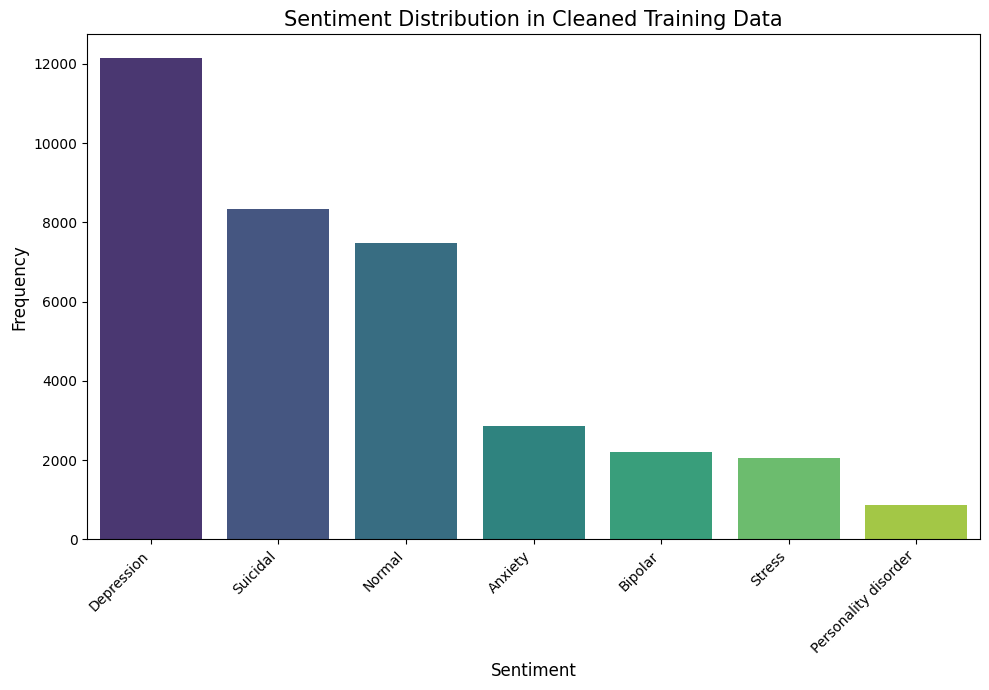

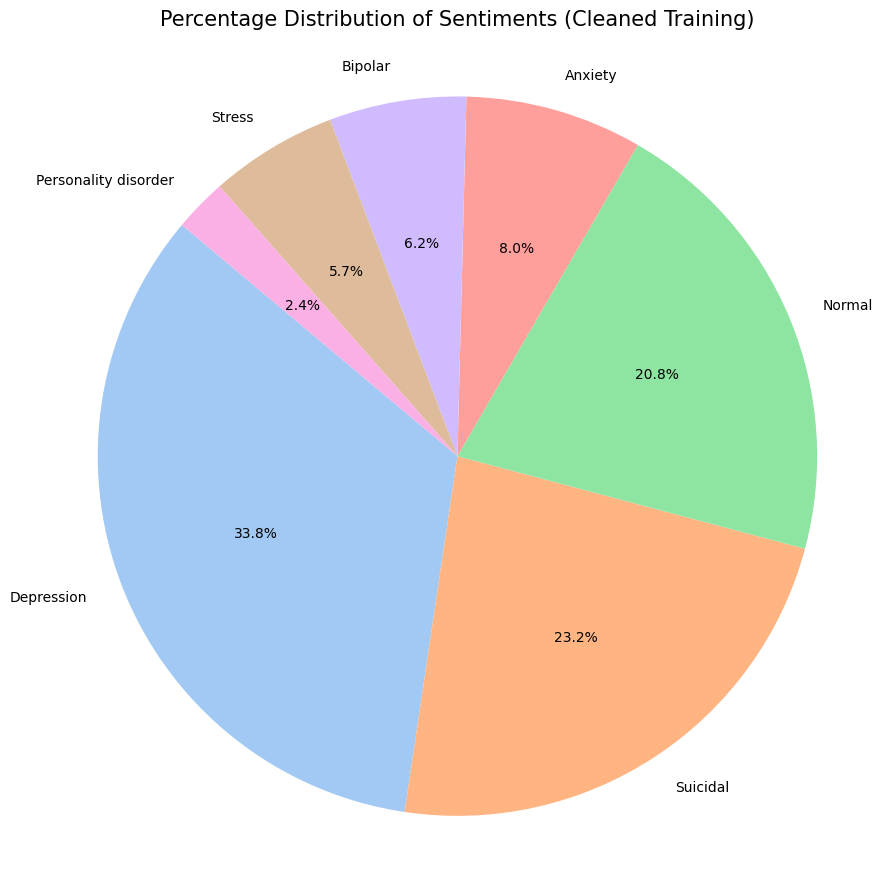

In [19]:
print("\n Exploratory Data Analysis on Cleaned Training Data")
# Sentiment Frequency Bar Chart
if not y_train_cleaned.empty:
    plt.figure(figsize=(10, 7))
    sentiment_counts_train = y_train_cleaned.map(id_to_label).value_counts()
    sns.barplot(x=sentiment_counts_train.index, y=sentiment_counts_train.values, palette="viridis")
    plt.title('Sentiment Distribution in Cleaned Training Data', fontsize=15)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Sentiment', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sentiment_distribution_train_cleaned_bar.png'))
    plt.show()

    # Sentiment Frequency Pie Chart
    plt.figure(figsize=(9, 9))
    plt.pie(sentiment_counts_train, labels=sentiment_counts_train.index, autopct='%1.1f%%',
            startangle=140, colors=sns.color_palette('pastel'), textprops={'fontsize': 10})
    plt.title('Percentage Distribution of Sentiments (Cleaned Training)', fontsize=15)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sentiment_distribution_train_cleaned_pie.png'))
    plt.show()


## Word Clouds for each sentiment


 Generating Word Clouds for each sentiment class...


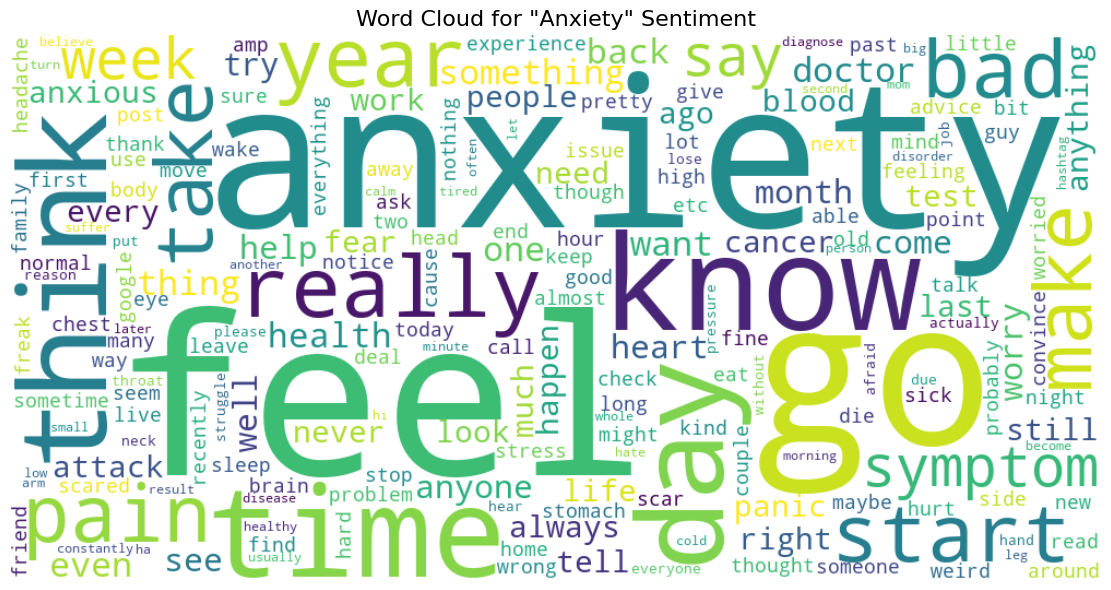

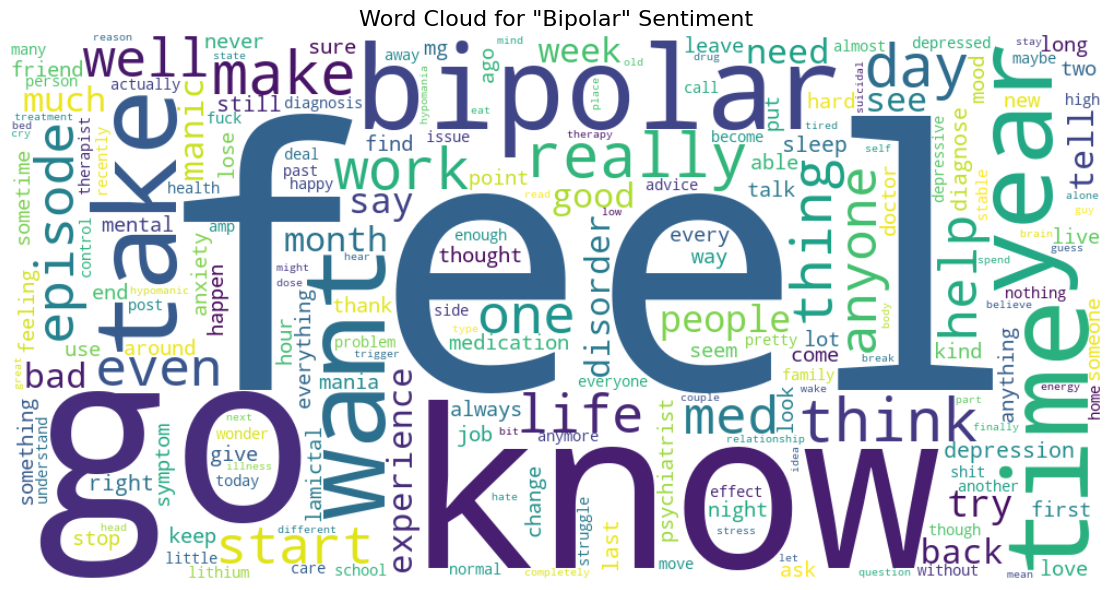

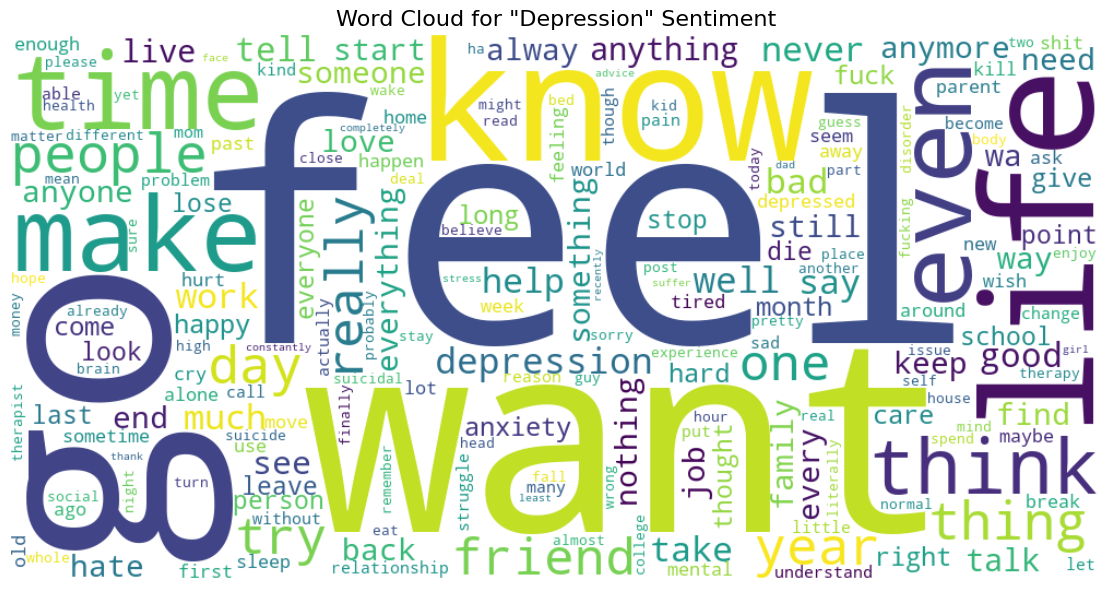

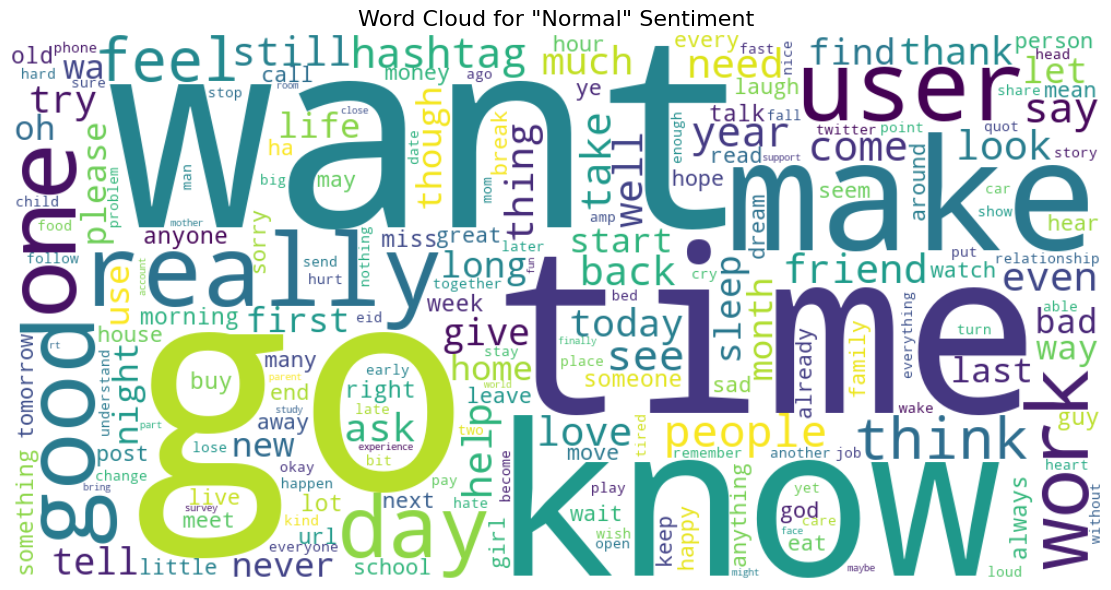

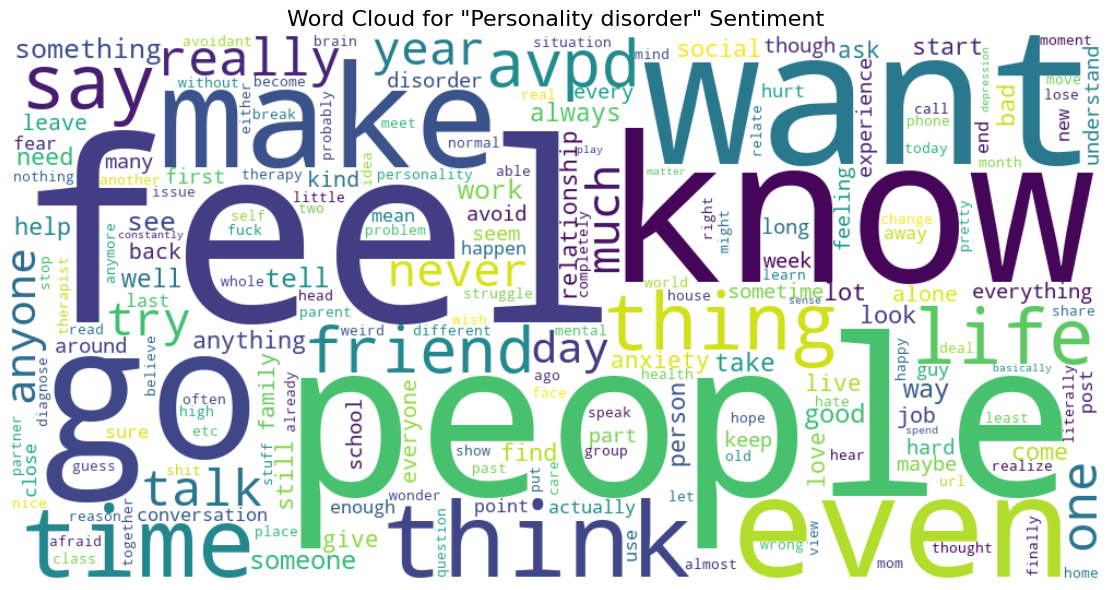

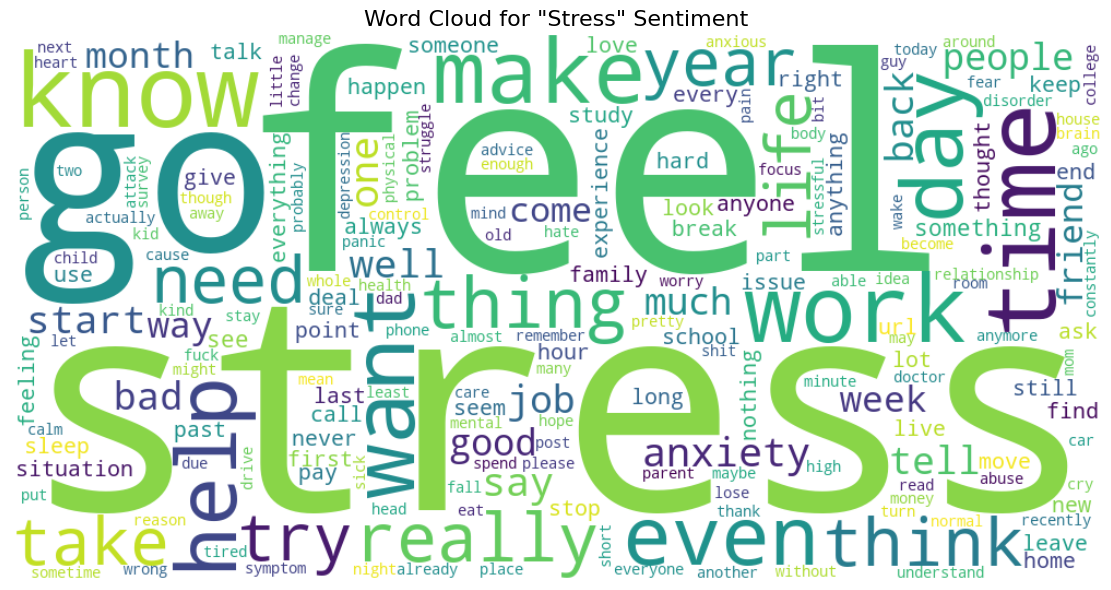

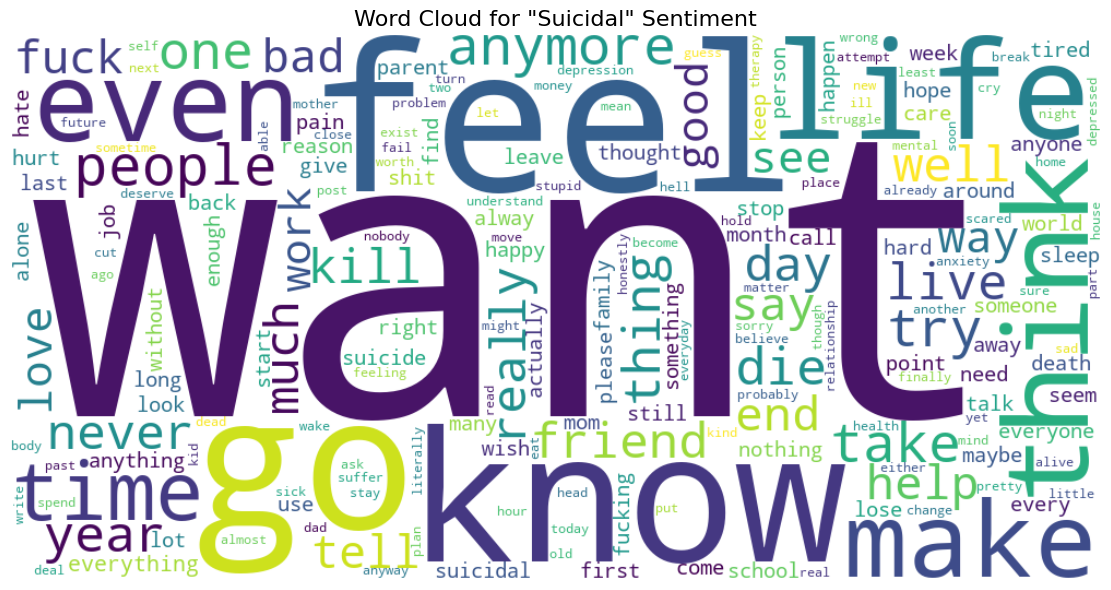

In [20]:
if not X_train_cleaned.empty and not y_train_cleaned.empty:
    print("\n Generating Word Clouds for each sentiment class...")
    temp_df_for_wc = pd.DataFrame({'text': X_train_cleaned, 'label_id': y_train_cleaned})
    for current_label_id, current_label_name in id_to_label.items():
        subset_texts_wc = temp_df_for_wc[temp_df_for_wc['label_id'] == current_label_id]['text']
        if not subset_texts_wc.empty:
            combined_text_wc = " ".join([str(t) for t in subset_texts_wc.tolist() if t and t.strip()])
            if combined_text_wc: # Ensure there's text to generate from
                try:
                    wordcloud_obj = WordCloud(width=1000, height=500, background_color='white',
                                           colormap='viridis', stopwords=None, # Stopwords already removed
                                           collocations=False).generate(combined_text_wc) # Disable collocations for cleaner clouds
                    plt.figure(figsize=(12, 6))
                    plt.imshow(wordcloud_obj, interpolation='bilinear')
                    plt.axis("off")
                    plt.title(f'Word Cloud for "{current_label_name}" Sentiment', fontsize=16)
                    plt.tight_layout()
                    plt.savefig(os.path.join(OUTPUT_DIR, f'wordcloud_{current_label_name.replace(" ", "_").lower()}.png'))
                    plt.show()
                except ValueError as e_wc: # Catch errors if text is too short or only contains stopwords WordCloud might ignore
                    print(f"Could not generate word cloud for '{current_label_name}': {e_wc}.")
            else:
                print(f"No text content available for word cloud of '{current_label_name}' after combining.")
        else:
            print(f"No samples found for sentiment '{current_label_name}' to generate word cloud.")

## N-grams Visualization for each sentiment


 Generating N-gram plots for each sentiment class...


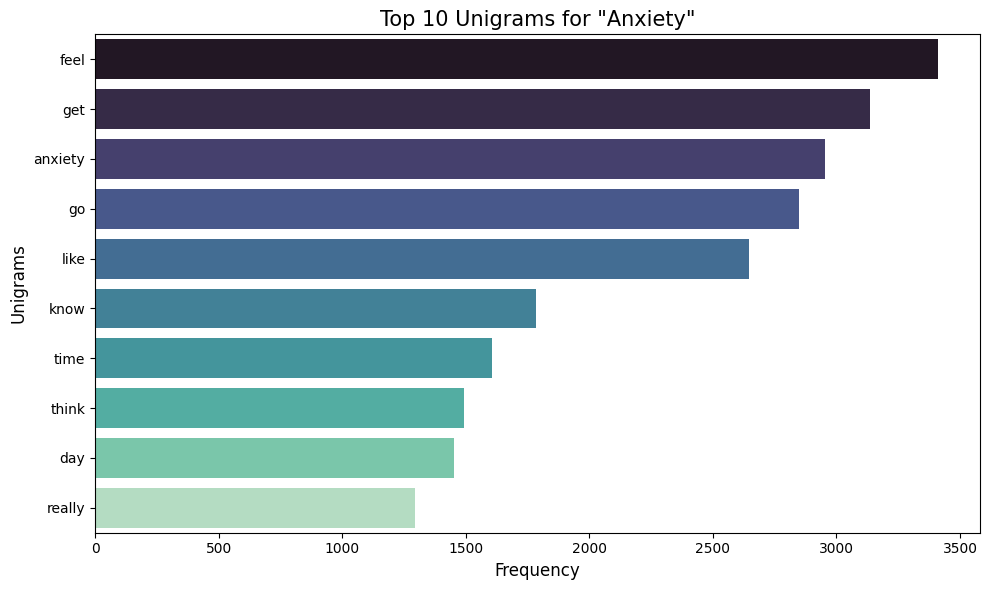

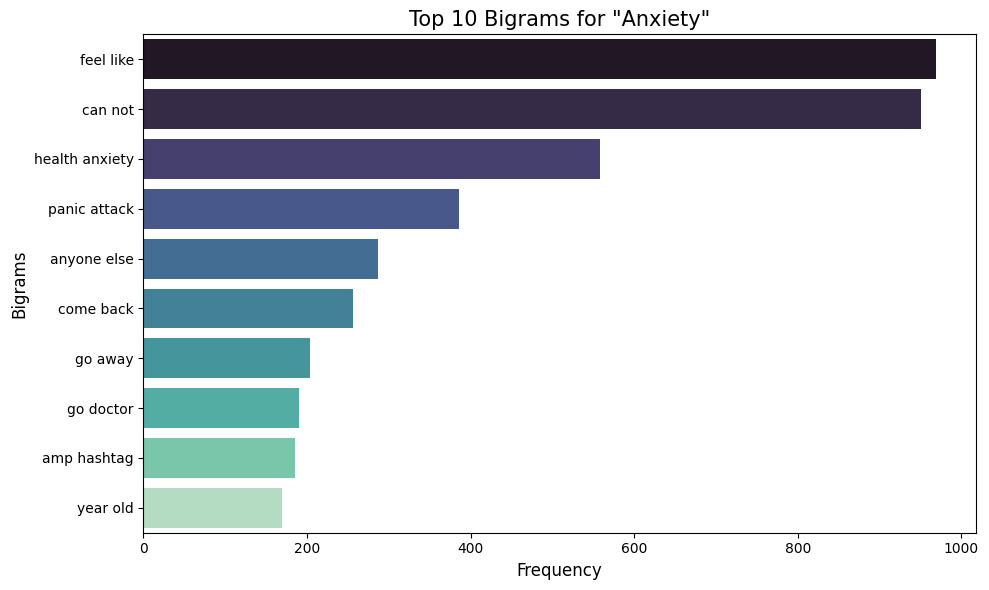

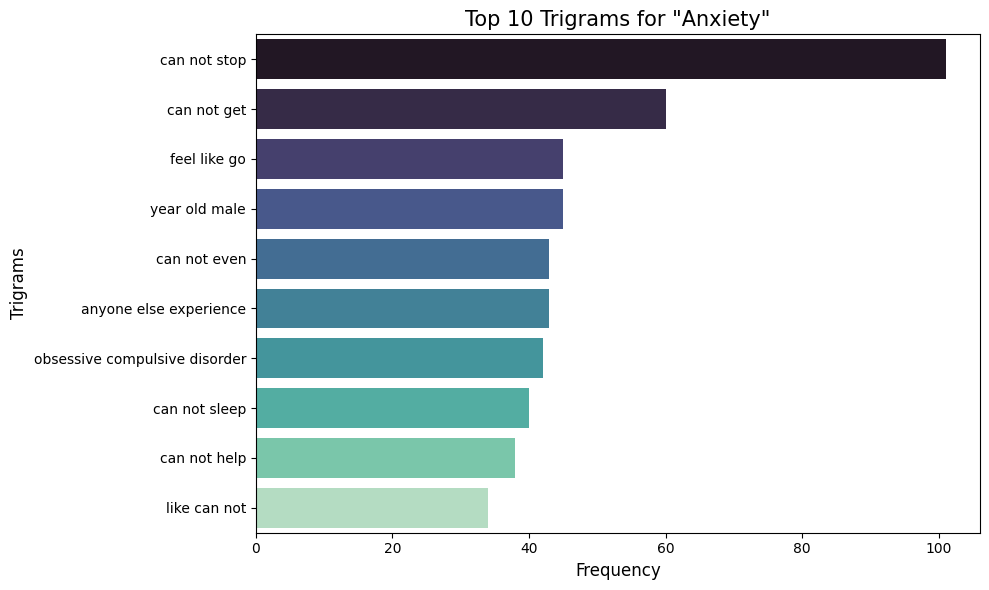

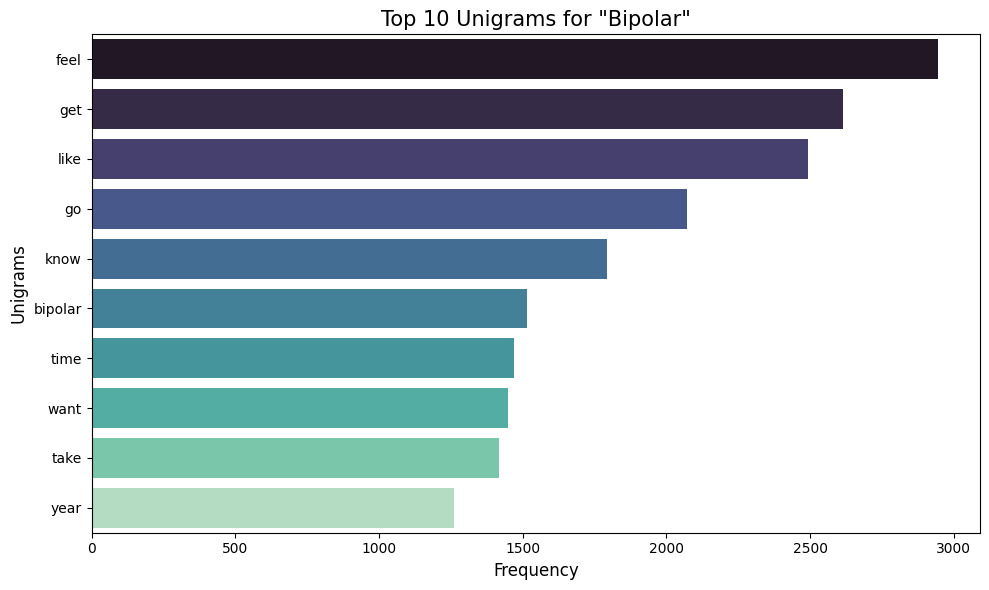

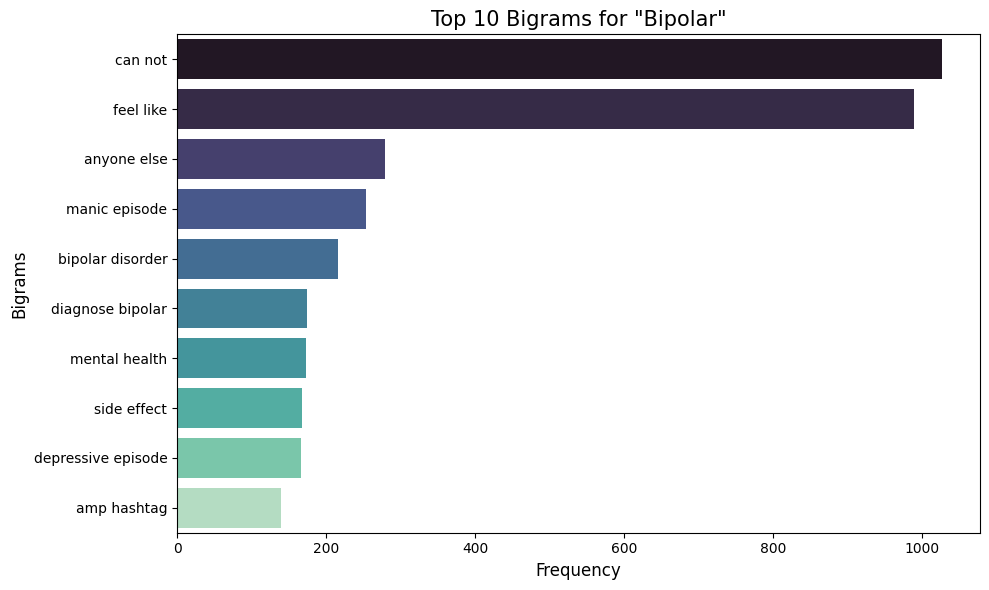

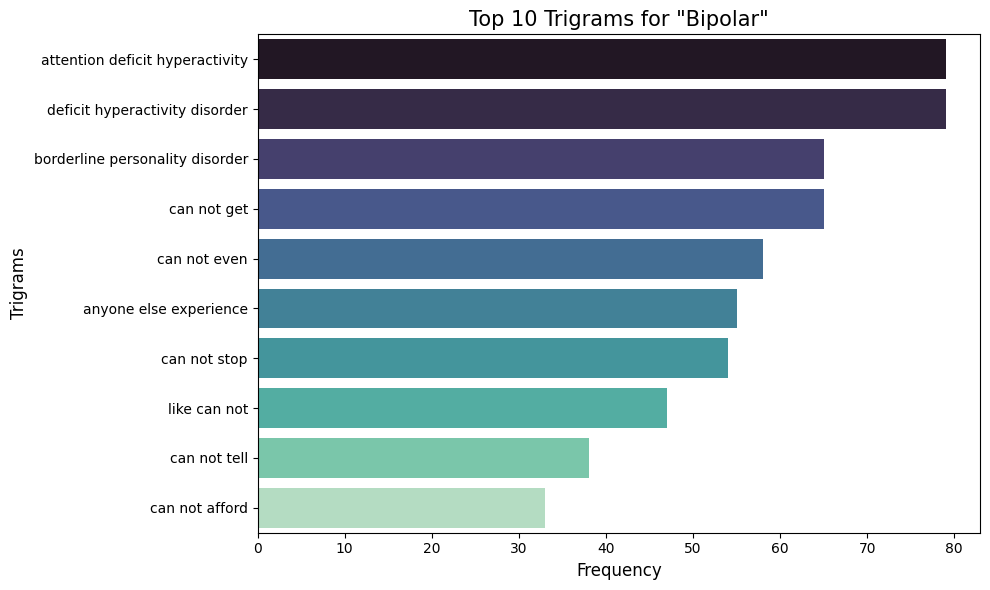

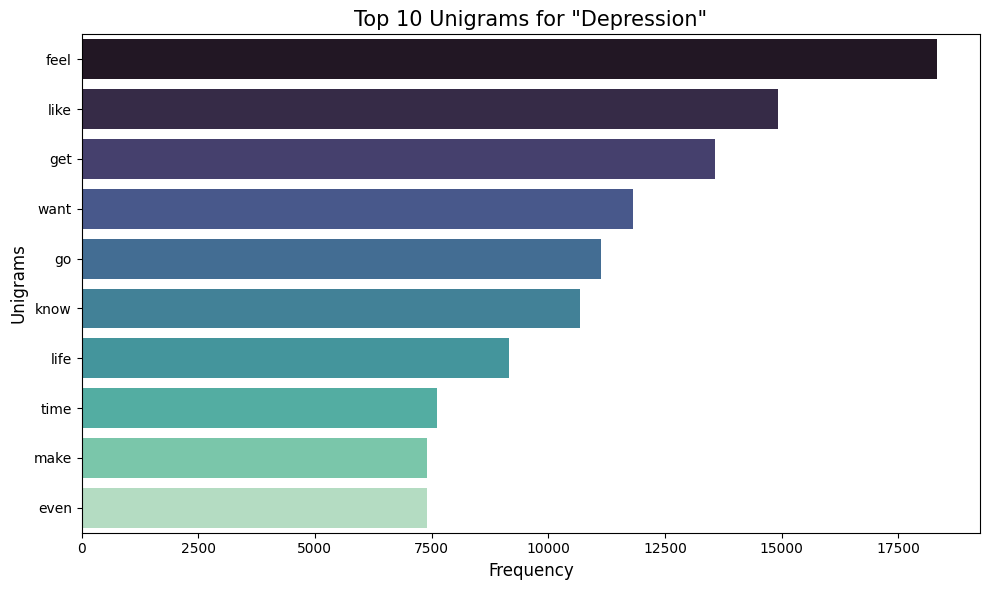

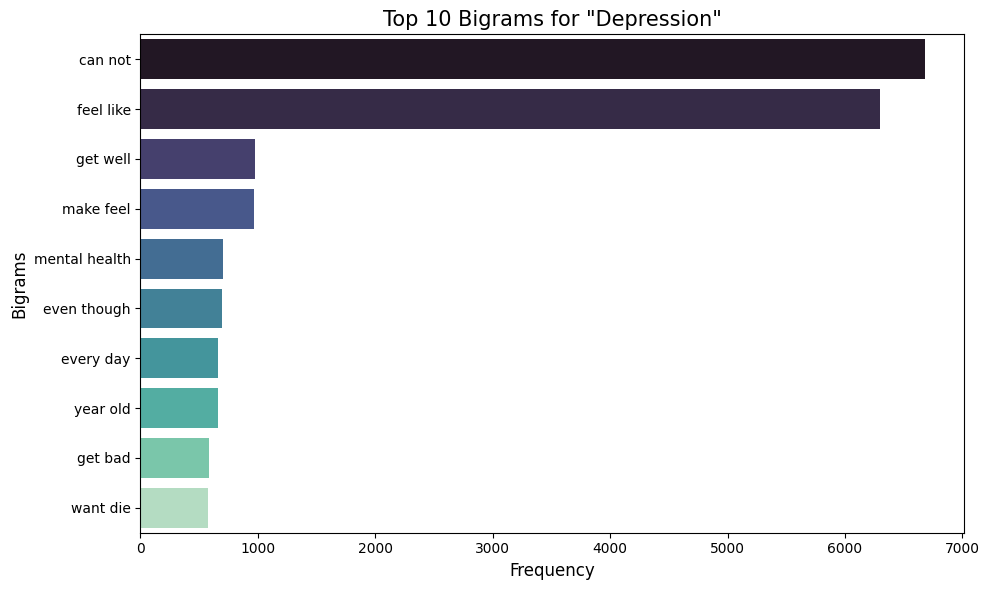

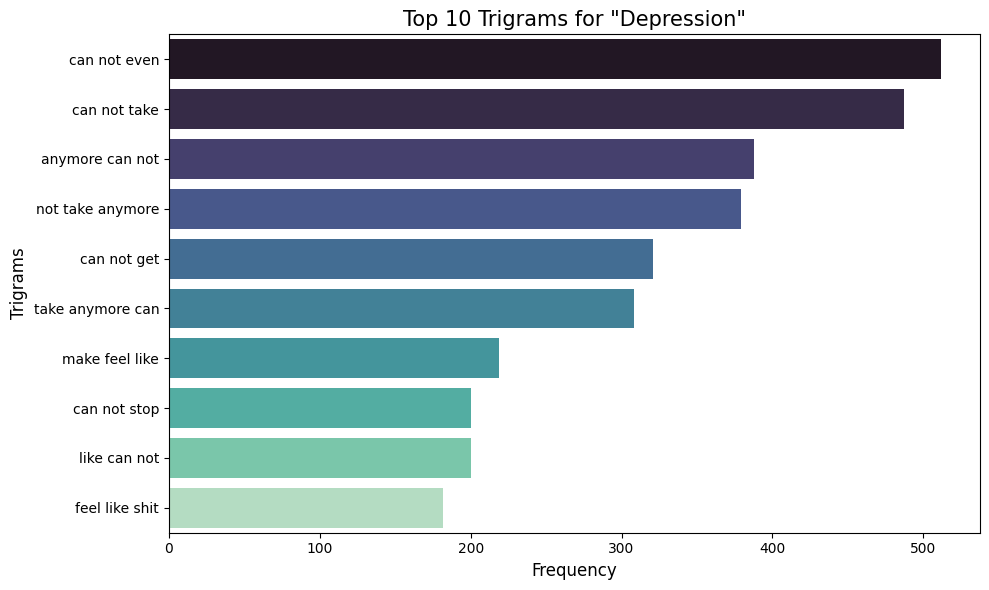

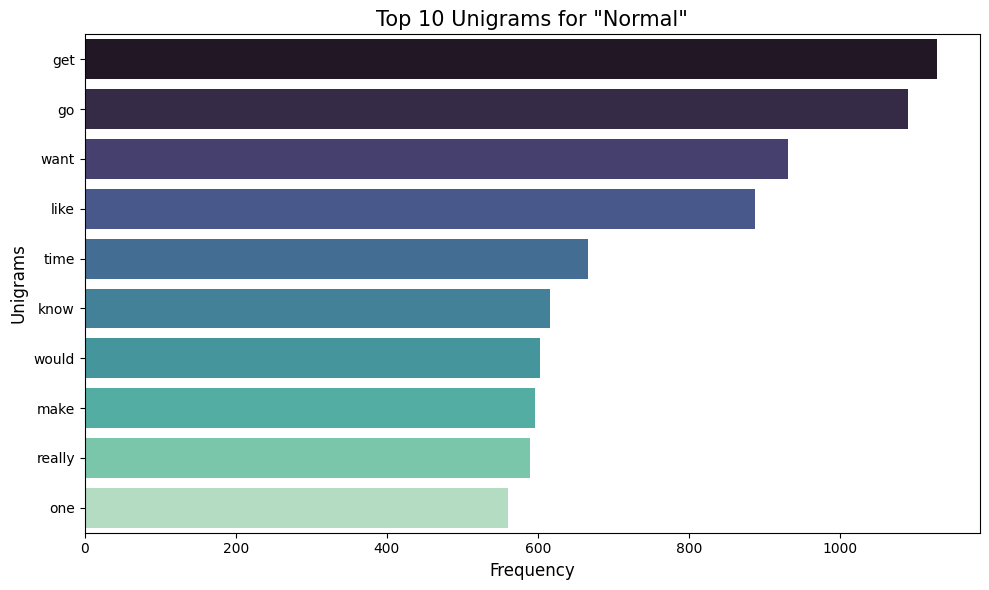

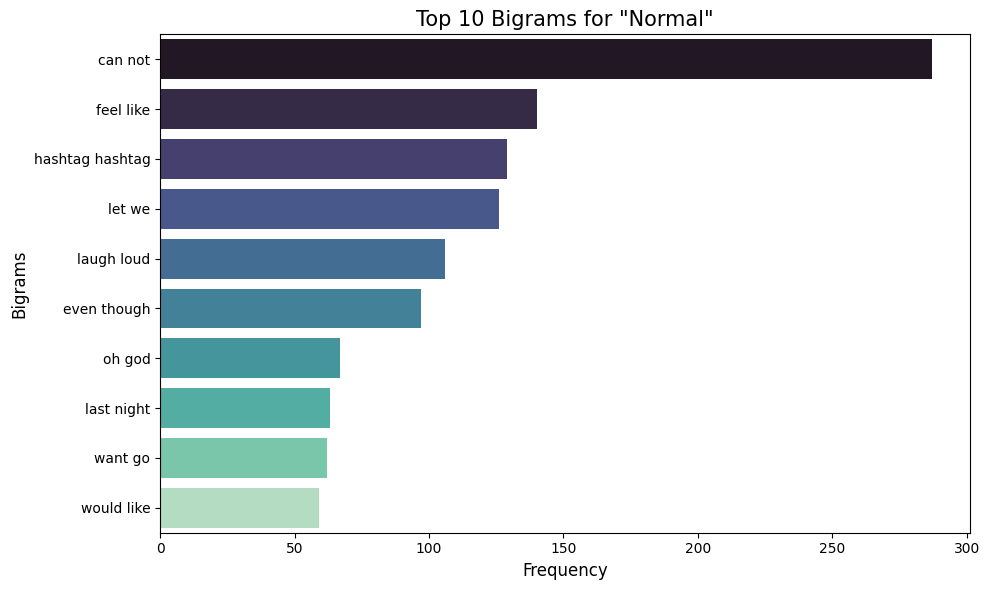

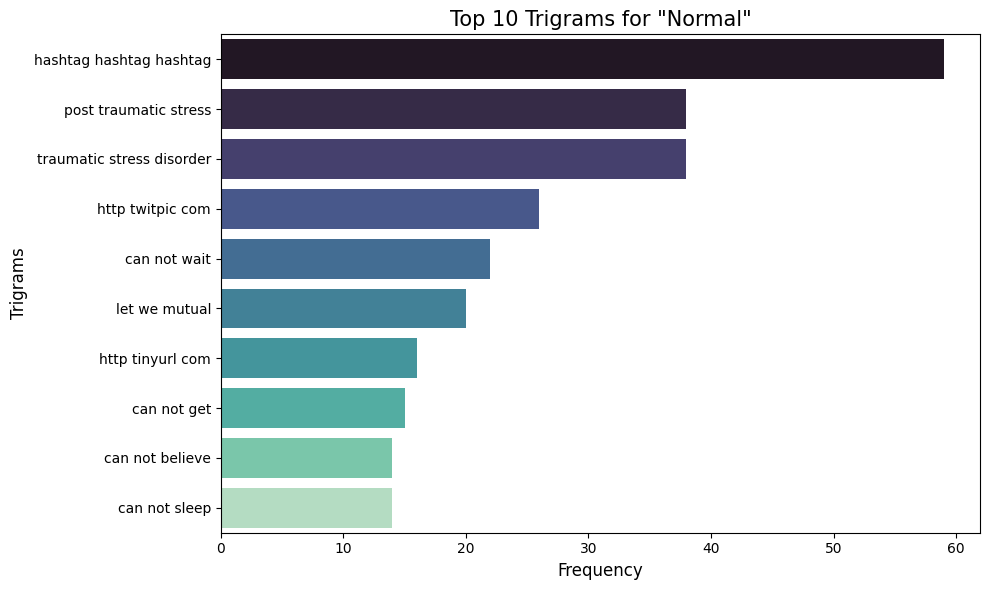

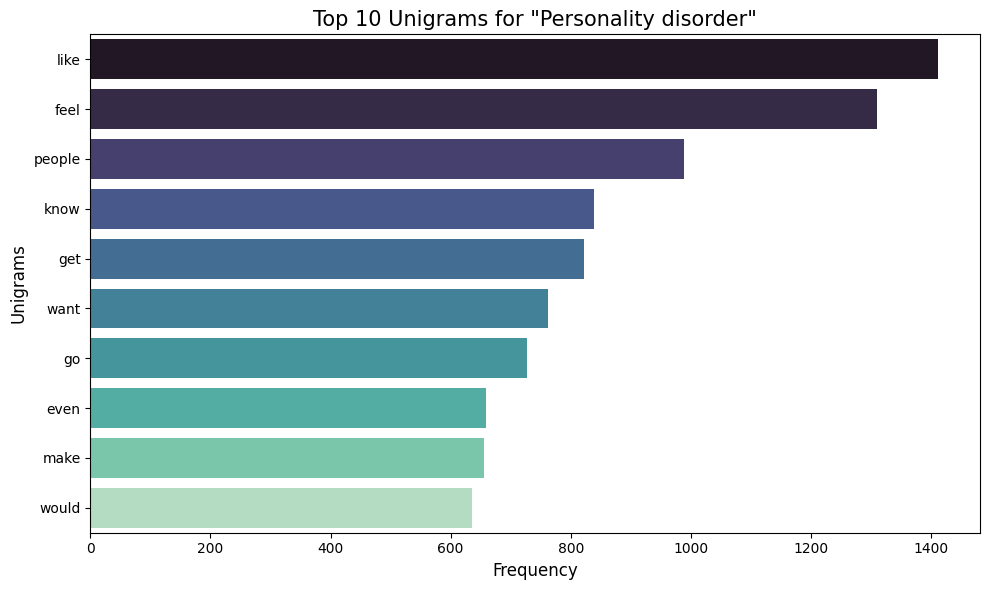

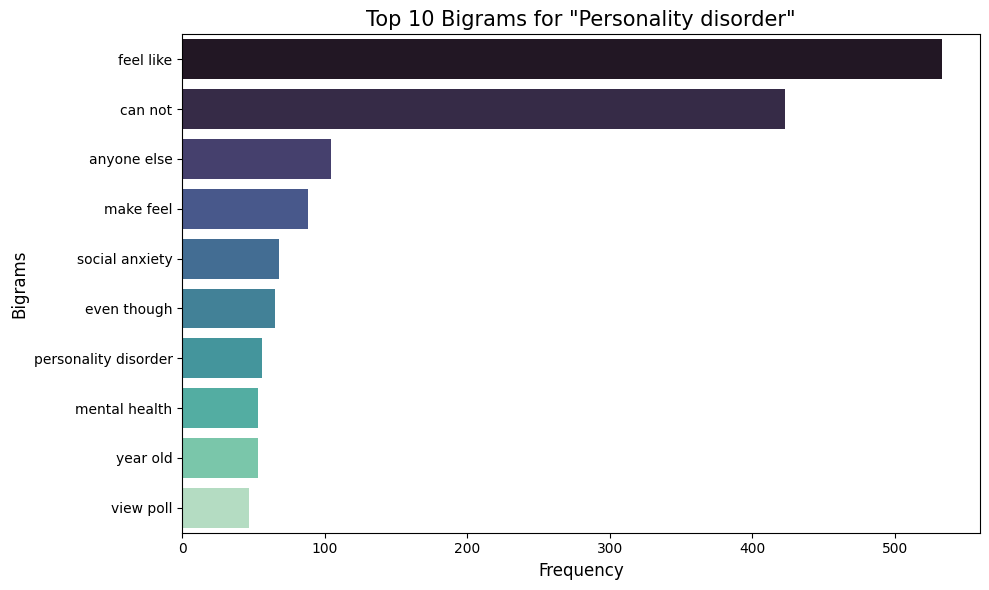

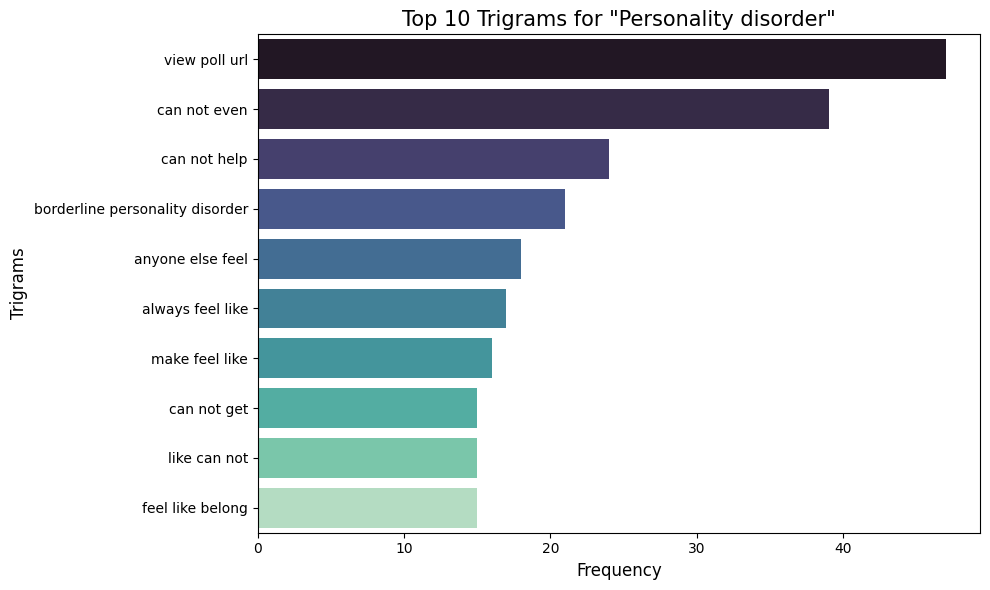

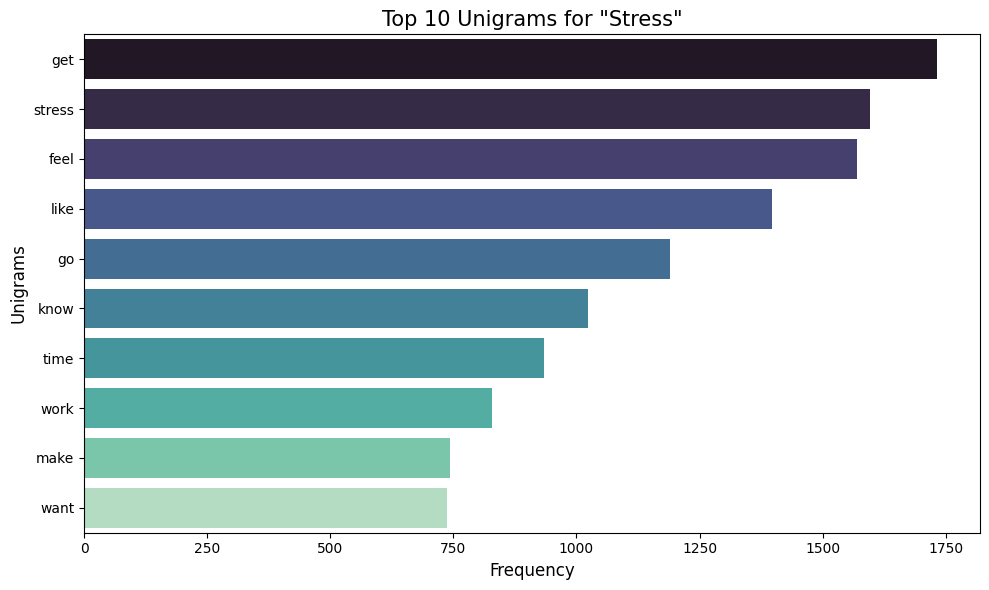

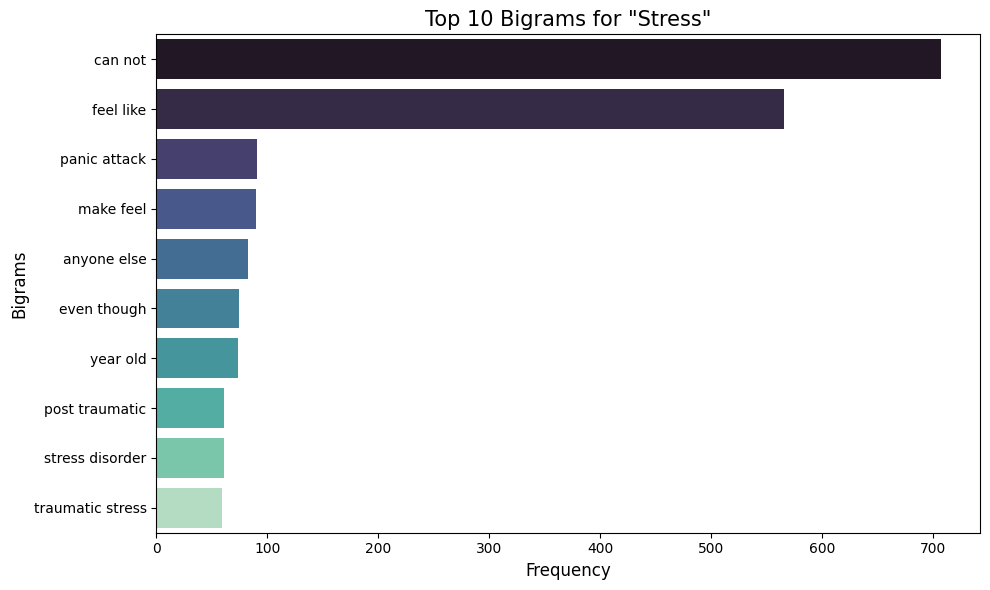

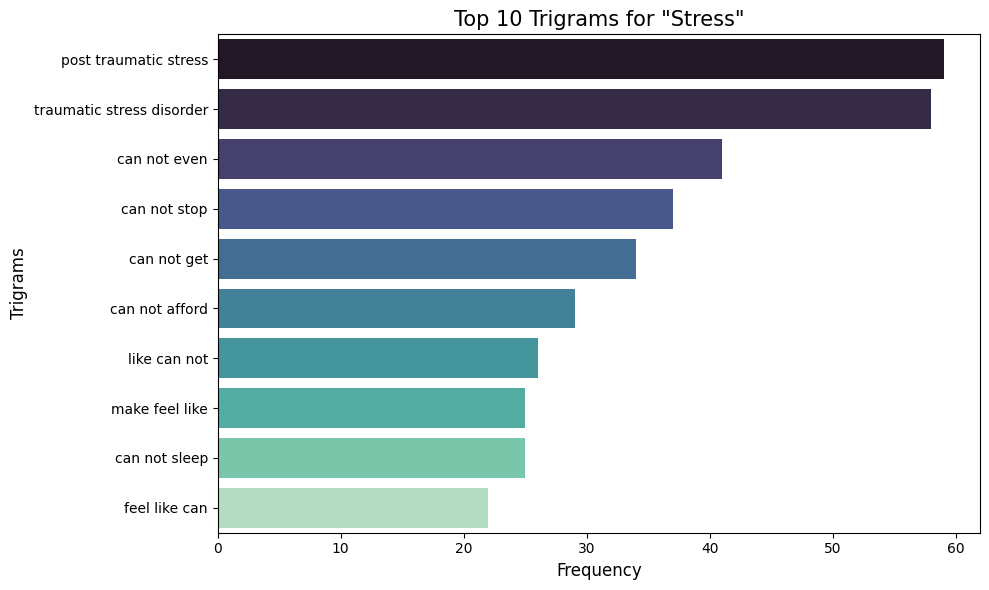

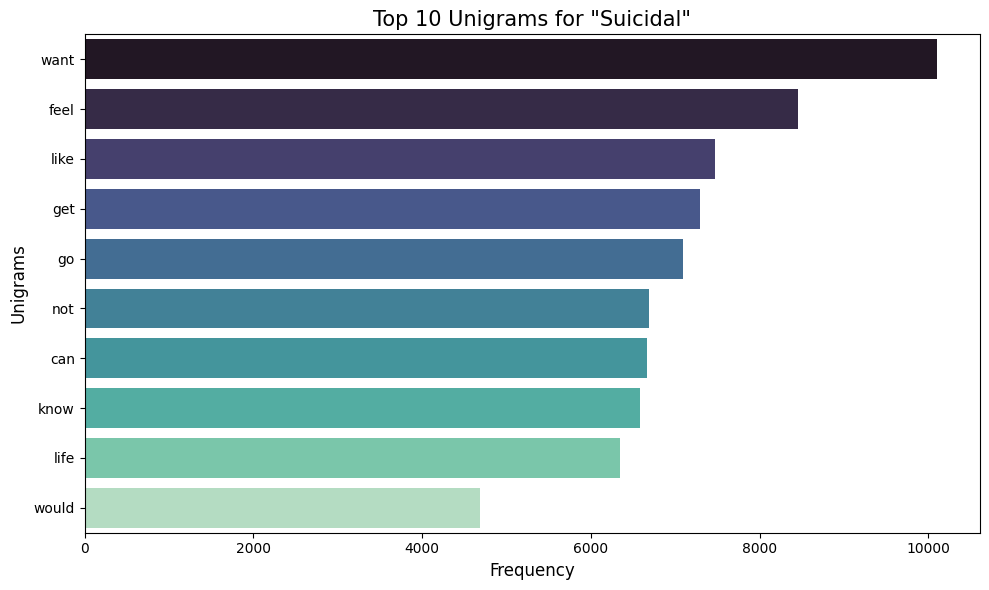

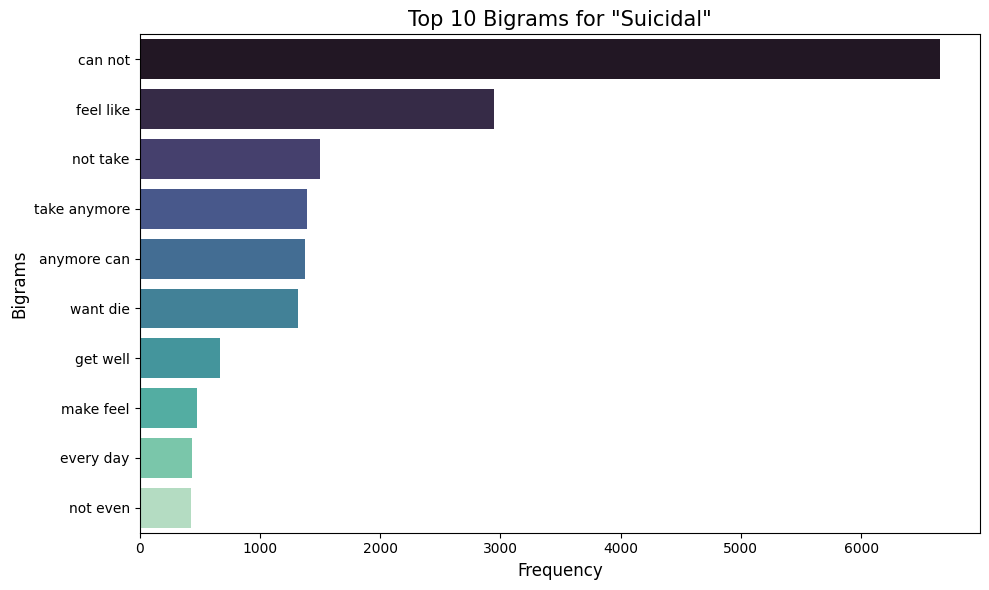

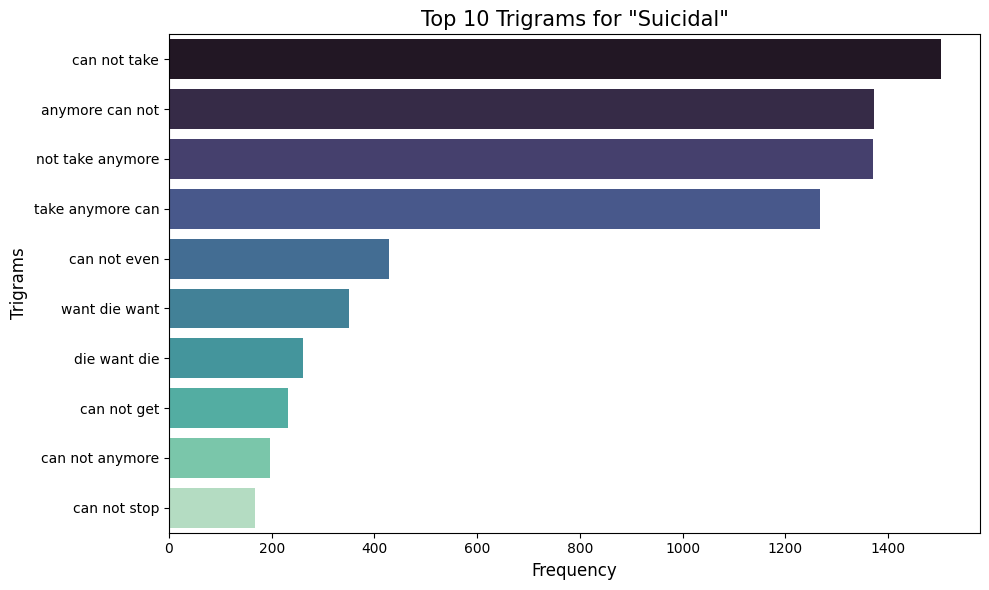

EDA Finished 


In [21]:
if not X_train_cleaned.empty and not y_train_cleaned.empty:
    print("\n Generating N-gram plots for each sentiment class...")
    temp_df_for_ngrams = pd.DataFrame({'text': X_train_cleaned, 'label_id': y_train_cleaned})

    def get_top_ngrams_eda(corpus_list, ngram_value=1, top_n_items=10):
        processed_corpus_list = [str(t) for t in corpus_list if t and isinstance(t, str) and t.strip()]
        if not processed_corpus_list: return []
        try:
            # CountVectorizer with min_df=2 to ignore very rare n-grams
            vectorizer = CountVectorizer(stop_words=None, ngram_range=(ngram_value, ngram_value),
                                         max_features=2000, min_df=2).fit(processed_corpus_list)
            bag_of_words_matrix = vectorizer.transform(processed_corpus_list)
            sum_of_words = bag_of_words_matrix.sum(axis=0)
            words_frequencies = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
            words_frequencies = sorted(words_frequencies, key=lambda x: x[1], reverse=True)
            return words_frequencies[:top_n_items]
        except ValueError: # Handles cases like empty vocabulary if min_df is too high for the data
            return []

    ngram_types_to_plot = {1: 'Unigrams', 2: 'Bigrams', 3: 'Trigrams'}
    num_top_ngrams = 10

    for current_label_id, current_label_name in id_to_label.items():
        subset_corpus_ngrams = temp_df_for_ngrams[temp_df_for_ngrams['label_id'] == current_label_id]['text'].tolist()
        if subset_corpus_ngrams and any(t.strip() for t in subset_corpus_ngrams): # Check if list contains non-empty strings
            for ngram_val, ngram_name in ngram_types_to_plot.items():
                # FIX: Changed 'ngram_val=ngram_val' to 'ngram_value=ngram_val'
                top_ngrams_list = get_top_ngrams_eda(subset_corpus_ngrams, ngram_value=ngram_val, top_n_items=num_top_ngrams)
                if top_ngrams_list:
                    ngram_words, ngram_freqs = zip(*top_ngrams_list)
                    plt.figure(figsize=(10, max(5, num_top_ngrams // 1.5))) # Dynamic height
                    sns.barplot(x=list(ngram_freqs), y=list(ngram_words), palette='mako')
                    plt.title(f'Top {num_top_ngrams} {ngram_name} for "{current_label_name}"', fontsize=15)
                    plt.xlabel('Frequency', fontsize=12)
                    plt.ylabel(ngram_name, fontsize=12)
                    plt.xticks(fontsize=10); plt.yticks(fontsize=10)
                    plt.tight_layout()
                    plt.savefig(os.path.join(OUTPUT_DIR, f'ngrams_{ngram_name.lower()}_{current_label_name.replace(" ", "_").lower()}.png'))
                    plt.show()
                else:
                    print(f"Could not generate {ngram_name} for '{current_label_name}' (e.g., not enough distinct n-grams meeting min_df).")
        else:
            print(f"No text content available for N-grams of '{current_label_name}'.")

print("EDA Finished ")

## Baseline Model: Logistic Regression


 Baseline Model: Logistic Regression
TF-IDF matrix shape for training (Baseline): (35957, 5000)
TF-IDF matrix shape for test (Baseline): (9004, 5000)
Performing GridSearchCV for Logistic Regression with 3 CV splits...
Error during Logistic Regression GridSearchCV: Parameter grid for parameter 'class_weight' needs to be a list or a numpy array, but got 'balanced' (of type str) instead. Single values need to be wrapped in a list with one element.
Attempting to train a default Logistic Regression model as fallback.

 Logistic Regression - Test Set Evaluation:
                      precision    recall  f1-score   support

             Anxiety       0.73      0.78      0.75       713
             Bipolar       0.74      0.76      0.75       556
          Depression       0.75      0.63      0.68      3031
              Normal       0.78      0.90      0.83      1900
Personality disorder       0.48      0.65      0.55       212
              Stress       0.49      0.56      0.53       518
 

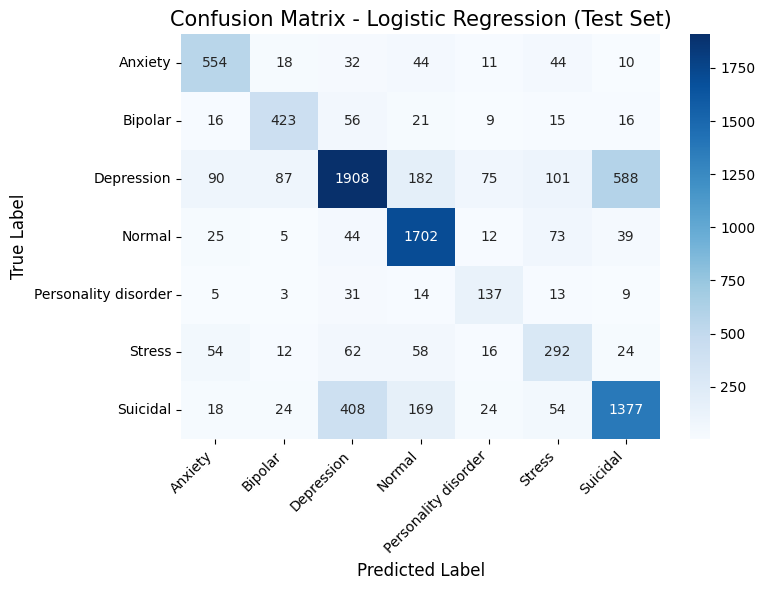

Baseline Model Finished


In [22]:
print("\n Baseline Model: Logistic Regression")
best_lr_model = None # Initialize baseline model variable
if not X_train_cleaned.empty and not y_train_cleaned.empty and len(y_train_cleaned.unique()) > 1:
    # TF-IDF Vectorization
    tfidf_vectorizer_baseline = TfidfVectorizer(
        max_features=MAX_FEATURES_TFIDF,
        min_df=3, # Ignore terms that appear in less than 3 documents
        ngram_range=(1, 2) # Consider both unigrams and bigrams
    )
    # Fit on the cleaned training data (which is already a Series)
    X_train_tfidf_baseline = tfidf_vectorizer_baseline.fit_transform(X_train_cleaned)
    print(f"TF-IDF matrix shape for training (Baseline): {X_train_tfidf_baseline.shape}")

    X_test_tfidf_baseline = None
    if not X_test_cleaned.empty:
        X_test_tfidf_baseline = tfidf_vectorizer_baseline.transform(X_test_cleaned)
        print(f"TF-IDF matrix shape for test (Baseline): {X_test_tfidf_baseline.shape}")
    else:
        print("No cleaned test data available for TF-IDF transformation (Baseline).")

    # Hyperparameter Tuning for Logistic Regression using GridSearchCV
    param_grid_lr = [
        {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 50], 'class_weight': ['balanced', None]},
        {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 50], 'class_weight': ['balanced', None], 'max_iter': [4000]} # saga often needs more iterations
    ]

    min_samples_per_class_lr = y_train_cleaned.value_counts().min()
    cv_splits_lr = min(N_SPLITS_CV_BASELINE, min_samples_per_class_lr if min_samples_per_class_lr is not None and min_samples_per_class_lr > 1 else N_SPLITS_CV_BASELINE)
    if cv_splits_lr < 2: cv_splits_lr = 2 # GridSearchCV requires at least 2 splits

    if X_train_tfidf_baseline.shape[0] >= cv_splits_lr and len(y_train_cleaned.unique()) >= cv_splits_lr :
        print(f"Performing GridSearchCV for Logistic Regression with {cv_splits_lr} CV splits...")

        filtered_param_grid_lr = []
        # Use ParameterGrid to iterate through all combinations
        for p in ParameterGrid(param_grid_lr):
            # liblinear supports l1 and l2
            if p['solver'] == 'liblinear' and p['penalty'] in ['l1', 'l2']:
                filtered_param_grid_lr.append(p)
            # saga supports l1, l2, and elasticnet (elasticnet needs l1_ratio)
            elif p['solver'] == 'saga' and p['penalty'] in ['l1', 'l2']:
                 filtered_param_grid_lr.append(p)
            # Add the case for None class_weight as well, for supported solvers/penalties
            elif p['solver'] in ['liblinear', 'saga'] and p['class_weight'] is None and p['penalty'] in ['l1', 'l2']:
                 filtered_param_grid_lr.append(p)


        # Remove duplicates by converting to frozenset and back to dict
        unique_filtered_param_grid_lr = [dict(s) for s in set(frozenset(d.items()) for d in filtered_param_grid_lr)]

        if not unique_filtered_param_grid_lr: # Fallback if filtering is too aggressive
            print("Warning: Filtered parameter grid for Logistic Regression is empty or invalid. Using original grid.")
            unique_filtered_param_grid_lr = list(ParameterGrid(param_grid_lr)) # Convert to list

        grid_search_lr_obj = GridSearchCV(
            LogisticRegression(max_iter=4000, random_state=SEED),
            unique_filtered_param_grid_lr, # Use the filtered grid
            cv=KFold(n_splits=cv_splits_lr, shuffle=True, random_state=SEED),
            scoring='f1_weighted', # F1-score is good for potentially imbalanced classes
            n_jobs=-1, # Use all available cores
            error_score='raise' # Raise errors during CV to catch issues
        )
        try:
            grid_search_lr_obj.fit(X_train_tfidf_baseline, y_train_cleaned)
            best_lr_model = grid_search_lr_obj.best_estimator_
            print(f"Best Logistic Regression Parameters (CV): {grid_search_lr_obj.best_params_}")
            print(f"Best Logistic Regression F1-weighted score (CV): {grid_search_lr_obj.best_score_:.4f}")
        except Exception as e_lr_cv:
            print(f"Error during Logistic Regression GridSearchCV: {e_lr_cv}")
            print("Attempting to train a default Logistic Regression model as fallback.")
            # Fallback model with balanced class weight and a suitable solver
            best_lr_model = LogisticRegression(max_iter=4000, random_state=SEED, class_weight='balanced', solver='liblinear')
            try:
                 best_lr_model.fit(X_train_tfidf_baseline, y_train_cleaned)
            except Exception as e_fallback:
                 print(f"Error during fallback Logistic Regression training: {e_fallback}")
                 best_lr_model = None # Ensure best_lr_model is None if fallback also fails


    else:
        print("Skipping Logistic Regression GridSearchCV due to insufficient samples/classes for cross-validation.")
        print("Training a default Logistic Regression model instead.")

        best_lr_model = LogisticRegression(max_iter=4000, random_state=SEED, class_weight='balanced', solver='liblinear')
        try:
             best_lr_model.fit(X_train_tfidf_baseline, y_train_cleaned)
        except Exception as e_default:
             print(f"Error during default Logistic Regression training: {e_default}")
             best_lr_model = None # Ensure best_lr_model is None if default training fails

    # Evaluate Baseline Model on Test Set
    if best_lr_model and X_test_tfidf_baseline is not None and not y_test_cleaned.empty:
        y_pred_lr_test = best_lr_model.predict(X_test_tfidf_baseline)
        print("\n Logistic Regression - Test Set Evaluation:")

        # Get unique labels present in both true and predicted values for the confusion matrix and report
        unique_y_test = sorted(np.unique(y_test_cleaned))
        unique_y_pred_lr_test = sorted(np.unique(y_pred_lr_test))
        all_labels_for_cm = sorted(list(set(unique_y_test + unique_y_pred_lr_test)))
        all_target_names_for_cm = [id_to_label.get(i, str(i)) for i in all_labels_for_cm]


        # Use all_labels_for_cm and all_target_names_for_cm for the classification report as well
        print(classification_report(y_test_cleaned, y_pred_lr_test, labels=all_labels_for_cm, target_names=all_target_names_for_cm, zero_division=0))

        # Confusion Matrix for Baseline Model
        cm_lr_test = confusion_matrix(y_test_cleaned, y_pred_lr_test, labels=all_labels_for_cm)
        plt.figure(figsize=(max(8, len(all_target_names_for_cm)), max(6, len(all_target_names_for_cm)*0.8))) # Dynamic size
        sns.heatmap(cm_lr_test, annot=True, fmt='d', cmap='Blues',
                    xticklabels=all_target_names_for_cm,
                    yticklabels=all_target_names_for_cm)
        plt.title('Confusion Matrix - Logistic Regression (Test Set)', fontsize=15)
        plt.xlabel('Predicted Label', fontsize=12); plt.ylabel('True Label', fontsize=12)
        plt.xticks(fontsize=10, rotation=45, ha='right'); plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_lr_test.png'))
        plt.show()
    elif best_lr_model:
        print("Skipping Logistic Regression test set evaluation: Cleaned test data (TF-IDF) or test labels are unavailable or empty.")
    else:
        print("Skipping Logistic Regression test set evaluation: Model training failed.")

# This 'else' block correctly matches the initial 'if' block
else:
    print("Skipping Logistic Regression training and evaluation: Cleaned training data is empty or has only a single class.")

print("Baseline Model Finished")

## Advanced Transformer Model (RoBERTa) with Regularization

In [ ]:
# ✅ Fully Corrected DistilRoBERTa Training Script
# Clean, syntax‑error‑free, ready to run in Jupyter / VS Code

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import pandas as pd

# ========================== CONFIG =============================
MODEL_NAME_DL = "distilroberta-base"
MAX_LEN_DL = globals().get('MAX_LEN_DL', 128)
BATCH_SIZE_DL = globals().get('BATCH_SIZE_DL', 8)
EPOCHS_DL = globals().get('EPOCHS_DL', 2)
VALIDATION_SPLIT_SIZE = globals().get('VALIDATION_SPLIT_SIZE', 0.1)
LEARNING_RATE_DL = globals().get('LEARNING_RATE_DL', 2e-5)
WEIGHT_DECAY_DL = globals().get('WEIGHT_DECAY_DL', 0.01)
DROPOUT_RATE_DL = globals().get('DROPOUT_RATE_DL', 0.2)
PATIENCE_EPOCHS = globals().get('PATIENCE_EPOCHS', 2)
OUTPUT_DIR = globals().get('OUTPUT_DIR', './output_mental_health_sentiment_v3_reg')
SEED = globals().get('SEED', 42)

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== DATASET CLASS ===========================
class SentimentDLDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# =================== TRAIN EPOCH ===============================
def train_epoch(model, loader, loss_fn, optimizer, scheduler, device):
    model.train()
    total_loss, correct = 0, 0
    total_items = len(loader.dataset)

    for batch in tqdm(loader, desc="Training", leave=False):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=ids, attention_mask=mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        total_loss += loss.item() * ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler: scheduler.step()

    return correct / total_items, total_loss / total_items

# =================== EVAL LOOP ================================
def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, correct = 0, 0
    preds_all, labels_all = [], []

    total_items = len(loader.dataset)
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item() * ids.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()

            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(labels.cpu().tolist())

    return correct / total_items, total_loss / total_items, preds_all, labels_all

# ================== PREPARE DATA ===============================
print(f"\n🔧 Preparing DistilRoBERTa model: {MODEL_NAME_DL}\n")

train_dataloader_dl_actual = val_dataloader_dl = test_dataloader_dl_final = None
roberta_model = roberta_tokenizer = None
loss_fn_train = loss_fn_eval = None
model_loaded_for_final_test = None

# Check training data exists
data_ready = (
    'X_train_cleaned' in globals() and 'y_train_cleaned' in globals() and
    not X_train_cleaned.empty and not y_train_cleaned.empty
)

if not data_ready:
    print("❌ Training skipped: cleaned training data missing.")
else:
    # Tokenizer
    roberta_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_DL)

    # Train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_cleaned.tolist(), y_train_cleaned.tolist(),
        test_size=VALIDATION_SPLIT_SIZE, random_state=SEED, stratify=y_train_cleaned
    )

    # Dataset + DataLoader
    train_dataset = SentimentDLDataset(X_train, y_train, roberta_tokenizer, MAX_LEN_DL)
    val_dataset = SentimentDLDataset(X_val, y_val, roberta_tokenizer, MAX_LEN_DL)

    train_dataloader_dl_actual = DataLoader(train_dataset, batch_size=BATCH_SIZE_DL, shuffle=True)
    val_dataloader_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE_DL)

    # Model
    num_labels = len(set(y_train_cleaned))
    roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_DL, num_labels=num_labels).to(device)

    # Loss + class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    loss_fn_train = nn.CrossEntropyLoss(weight=class_weights_tensor)
    loss_fn_eval = nn.CrossEntropyLoss()

    # Optimizer + scheduler
    optimizer = AdamW(roberta_model.parameters(), lr=LEARNING_RATE_DL, weight_decay=WEIGHT_DECAY_DL)
    total_steps = len(train_dataloader_dl_actual) * EPOCHS_DL
    scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * 0.1), total_steps)

    print("🚀 Training started...")

    best_val_acc = 0
    epochs_no_improve = 0
    training_history_dl = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    # ================== TRAINING LOOP ========================
    for epoch in range(EPOCHS_DL):
        print(f"📘 Epoch {epoch+1} / {EPOCHS_DL}")

        train_acc, train_loss = train_epoch(roberta_model, train_dataloader_dl_actual, loss_fn_train, optimizer, scheduler, device)
        val_acc, val_loss, _, _ = eval_epoch(roberta_model, val_dataloader_dl, loss_fn_eval, device)

        training_history_dl["train_acc"].append(train_acc)
        training_history_dl["train_loss"].append(train_loss)
        training_history_dl["val_acc"].append(val_acc)
        training_history_dl["val_loss"].append(val_loss)

        print(f"✔ Train acc={train_acc:.4f}, loss={train_loss:.4f}")
        print(f"✔ Val   acc={val_acc:.4f}, loss={val_loss:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            save_path = os.path.join(OUTPUT_DIR, "distilroberta-best")
            roberta_model.save_pretrained(save_path)
            roberta_tokenizer.save_pretrained(save_path)
            print(f"💾 Saved best model → {save_path}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE_EPOCHS:
                print("⛔ Early stopping triggered!")
                break

    # ================== LOAD BEST MODEL =====================
    best_model_dir = os.path.join(OUTPUT_DIR, "distilroberta-best")
    if os.path.exists(best_model_dir):
        print("📥 Loading best model for final test evaluation...")
        roberta_tokenizer = AutoTokenizer.from_pretrained(best_model_dir)
        model_loaded_for_final_test = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)

# ====================== TEST EVALUATION =========================
if model_loaded_for_final_test is None:
    print("❌ Cannot evaluate test set: no trained model found.")
else:
    if 'X_test_cleaned' in globals() and not X_test_cleaned.empty:
        test_dataset = SentimentDLDataset(X_test_cleaned.tolist(), y_test_cleaned.tolist(), roberta_tokenizer, MAX_LEN_DL)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_DL)

        test_acc, test_loss, preds, labels = eval_epoch(model_loaded_for_final_test, test_loader, loss_fn_eval, device)

        print(f"🎯 Test Accuracy: {test_acc:.4f}")
        print("Classification Report:")
        print(classification_report(labels, preds))
    else:
        print("⚠ No cleaned test data available.")



🔧 Preparing DistilRoBERTa model: distilroberta-base



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


🚀 Training started...
📘 Epoch 1 / 7


✔ Train acc=0.5385, loss=1.2053
✔ Val   acc=0.6593, loss=0.9087
💾 Saved best model → ./output_mental_health_sentiment_v3_reg\distilroberta-best
📘 Epoch 2 / 7


Training:  95%|█████████▍| 1912/2023 [4:22:39<16:28,  8.91s/it]  

## Prediction Example with Trained RoBERTa Model

In [24]:
def predict_sentiment_with_dl_model(raw_text_list, trained_model, tokenizer_instance, cleaning_fn, max_seq_len, torch_device, label_id_map):
    """Predicts sentiment for a list of raw texts using a trained DL model."""
    if trained_model is None or tokenizer_instance is None:
        return [{"original_text": rt, "cleaned_text": "N/A", "predicted_sentiment": "Model/Tokenizer not available", "probabilities": None} for rt in raw_text_list]

    trained_model.eval() # Ensure model is in evaluation mode
    prediction_results = []

    # Clean the input texts using the provided cleaning function (which should take a Series and return a Series)
    cleaned_texts_series = cleaning_fn(pd.Series(raw_text_list, name="PredictionInput"))

    for i, cleaned_text_item in enumerate(cleaned_texts_series):
        original_text_item = raw_text_list[i]
        if not cleaned_text_item.strip() or len(cleaned_text_item.split()) < MIN_WORDS_AFTER_CLEANING:
            prediction_results.append({
                "original_text": original_text_item, "cleaned_text": cleaned_text_item,
                "predicted_sentiment": "Text too short/empty after cleaning", "probabilities": None
            })
            continue

        encoding = tokenizer_instance.encode_plus(
            cleaned_text_item, add_special_tokens=True, max_length=max_seq_len,
            return_token_type_ids=False, padding='max_length', truncation=True,
            return_attention_mask=True, return_tensors='pt',
        )
        b_input_ids = encoding['input_ids'].to(torch_device)
        b_attention_mask = encoding['attention_mask'].to(torch_device)

        with torch.no_grad():
            outputs = trained_model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_label_id = torch.argmax(probabilities, dim=1).item()
        predicted_sentiment_str = label_id_map.get(predicted_label_id, "Unknown Label ID")

        all_class_probabilities = {label_id_map.get(j, str(j)): prob.item() for j, prob in enumerate(probabilities.cpu().squeeze())}

        prediction_results.append({
            "original_text": original_text_item,
            "cleaned_text": cleaned_text_item,
            "predicted_sentiment": predicted_sentiment_str,
            "probabilities": all_class_probabilities
        })
    return prediction_results

# Use the model loaded for final test evaluation for predictions, if available
if model_loaded_for_final_test and roberta_tokenizer:
    print(f"\n {MODEL_NAME_DL} Prediction Example (using model from test evaluation)")
    example_texts_for_prediction = [
        "I am feeling absolutely ecstatic and overjoyed today, everything is wonderful!",
        "The weight of this sadness is crushing me. I feel so empty and depressed.",
        "It's just another Monday. Not bad, not good, just... normal.",
        "My heart is racing with anxiety about the upcoming presentation. I can barely breathe.",
        "This new song is amazing! LOL, I've had it on repeat all day, GR8 vibes!"
    ]

    prediction_outputs_list = predict_sentiment_with_dl_model(
        example_texts_for_prediction, model_loaded_for_final_test, roberta_tokenizer,
        clean_text_series,
        MAX_LEN_DL, device, id_to_label
    )

    for item_result in prediction_outputs_list:
        print(f"\nOriginal Text: {item_result['original_text']}")
        print(f"Cleaned Text: {item_result['cleaned_text']}")
        print(f"Predicted Sentiment: {item_result['predicted_sentiment']}")
        if item_result['probabilities']:
            print("Class Probabilities:")
            for sentiment_class, probability_value in item_result['probabilities'].items():
                print(f"  - {sentiment_class}: {probability_value:.4f}")
else:
    print(f"\nSkipping {MODEL_NAME_DL} prediction example: Trained model or tokenizer from test phase is not available.")

print("\n ... Prediction Finished ... ")

# For ParameterGrid (used in Logistic Regression CV)
from sklearn.model_selection import ParameterGrid


Skipping roberta-base prediction example: Trained model or tokenizer from test phase is not available.

 ... Prediction Finished ... 



##### This notebook is a compassionate application of deep learning to:

##### - Classify mental health-related sentiments.  
##### - Amplify unseen emotional voices.  
##### - Enable proactive mental health support.

> **Join us** as we explore the data with sensitivity, build powerful models with purpose, and unveil the emotional heartbeat of mental health text. Together, we can make a difference. 🤝✨
